In [1]:
! pip uninstall agent-framework -y
! pip uninstall agent-framework-azure -y
! pip uninstall agent-framework-foundry -y
! pip uninstall agent-framework-viz -y

Found existing installation: agent-framework 0.1.0b1
Uninstalling agent-framework-0.1.0b1:
  Successfully uninstalled agent-framework-0.1.0b1


requirements.txt & constraints.txt - in ./Installation

please copy .env.examples as .env

In [2]:
! git config fetch.showForcedUpdates true

In [3]:
! pip install -r ../../../Installation/requirements.txt --constraint ../../../Installation/constraints.txt -U

  Cloning https://github.com/microsoft/agent-framework.git (to revision main) to c:\users\kinfeylo\appdata\local\temp\pip-install-jbdj_qs_\agent-framework_e5e00559de82426c95e40fb754aa4500
  Resolved https://github.com/microsoft/agent-framework.git to commit d235e741d0bec6c90398470d7bf9d8c6db7669cd
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Cloning https://github.com/microsoft/agent-framework.git (to revision main) to c:\users\kinfeylo\appdata\local\temp\pip-install-jbdj_qs_\agent-framework-azure-ai_5faec8339e3240d3982ab288a6ad2a58
  Resolved https://github.com/microsoft/agent-framework.git to commit d235e741d0bec6c90398470d7bf9d8c6db7669cd
  Installing build dependencies: started
  Installing build dep

  Running command git clone --filter=blob:none --quiet https://github.com/microsoft/agent-framework.git 'C:\Users\kinfeylo\AppData\Local\Temp\pip-install-jbdj_qs_\agent-framework_e5e00559de82426c95e40fb754aa4500'
  but that check has been disabled; to re-enable, use '--show-forced-updates'
  flag or run 'git config fetch.showForcedUpdates true'
  Running command git clone --filter=blob:none --quiet https://github.com/microsoft/agent-framework.git 'C:\Users\kinfeylo\AppData\Local\Temp\pip-install-jbdj_qs_\agent-framework-azure-ai_5faec8339e3240d3982ab288a6ad2a58'
  but that check has been disabled; to re-enable, use '--show-forced-updates'
  flag or run 'git config fetch.showForcedUpdates true'


In [4]:
! pip install azure-ai-projects -U
! pip install azure-ai-agents==1.2.0b4 -U
! pip install pydantic -U
! pip install azure-identity

In [5]:
import os

from dataclasses import dataclass
from typing_extensions import Literal
from pydantic import BaseModel

In [6]:

from azure.ai.projects.aio import AIProjectClient
from azure.identity.aio import AzureCliCredential
from dotenv import load_dotenv

from agent_framework import HostedWebSearchTool
from agent_framework.azure import AzureAIAgentClient
from agent_framework import (
    AgentExecutor,
    AgentExecutorRequest,
    AgentExecutorResponse,
    ChatAgent,
    HostedCodeInterpreterTool,
    ChatMessage,
    Role,
    WorkflowBuilder,
    WorkflowContext,
    WorkflowEvent,
    executor,
    WorkflowViz
)


from azure.ai.agents.models import BingGroundingTool,CodeInterpreterTool

In [7]:
load_dotenv()

True

In [8]:
EvangelistInstructions = """
You are a technology evangelist create a first draft for a technical tutorials.
1. Each knowledge point in the outline must include a link. Follow the link to access the content related to the knowledge point in the outline. Expand on that content.
2. Each knowledge point must be explained in detail.
3. Rewrite the content according to the entry requirements, including the title, outline, and corresponding content. It is not necessary to follow the outline in full order.
4. The content must be more than 200 words.
4. Output draft as Markdown format
"""

ContentReviewerInstructions = """
You are a content reviewer for a publishing company. You need to check whether the tutorial's draft content meets the following requirements:

1. The draft content less than 200 words, set 'review_result' to 'No' and 'reason' to 'Content is too short'. If the draft content is more than 200 words, set 'review_result' to 'Yes' and 'reason' to 'The content is good'.
2. set 'draft_content' to the original draft content.
3. return result as JSON with fields 'review_result' (one of Yes, No) and 'reason' (string) and 'draft_content' (string).

"""

PublisherInstructions = """
You are the content publisher ,run code to save the tutorial's draft content as a Markdown file. Saved file's name is marked with current date and time, such as yearmonthdayhourminsec. Note that if it is 1-9, you need to add 0, such as  20240101123045.md. 
"""

In [9]:
OUTLINE_Content ="""
# Introduce AI Agent


## What's AI Agent

https://github.com/microsoft/ai-agents-for-beginners/tree/main/01-intro-to-ai-agents


***Note*** Don's create any sample code 


## Introduce Azure AI Foundry Agent Service 

https://learn.microsoft.com/en-us/azure/ai-foundry/agents/overview


***Note*** Don's create any sample code 


## Microsoft Agent Framework 

https://github.com/microsoft/agent-framework/tree/main/docs/docs-templates


***Note*** Don's create any sample code 
"""

In [10]:
conn_id = os.environ["BING_CONNECTION_ID"]  # Ensure the BING_CONNECTION_NAME environment variable is set

# Initialize the Bing Grounding tool
bing = BingGroundingTool(connection_id=conn_id)

code_interpreter = CodeInterpreterTool()

In [11]:
class EvangelistAgent(BaseModel):
    draft_content: str

class ReviewAgent(BaseModel):
    review_result: Literal["Yes", "No"]
    reason: str
    draft_content: str

class PublisherAgent(BaseModel):
    file_path: str

@dataclass
class ReviewResult:
    review_result: str
    reason: str
    draft_content: str

@executor(id="to_reviewer_result")
async def to_reviewer_result(response: AgentExecutorResponse, ctx: WorkflowContext[ReviewResult]) -> None:

    print(f"Raw response from reviewer agent: {response.agent_run_response.text}")

    parsed = ReviewAgent.model_validate_json(response.agent_run_response.text)
    await ctx.send_message(
        ReviewResult(
            review_result=parsed.review_result,
            reason=parsed.reason,
            draft_content=parsed.draft_content,
        )
    )


def select_targets(review: ReviewResult, target_ids: list[str]) -> list[str]:
        # Order: [handle_review, submit_to_email_assistant, summarize_email, handle_uncertain]
        handle_review_id, save_draft_id = target_ids
        if review.review_result == "Yes":
            return [save_draft_id]
        else:
            return [handle_review_id]
        


@executor(id="handle_review")
async def handle_review(review: ReviewResult, ctx: WorkflowContext[str]) -> None:
    if review.review_result == "No":
        await ctx.yield_output(f"Review failed: {review.reason}, please revise the draft.")
    else:
        await ctx.send_message(
            AgentExecutorRequest(messages=[ChatMessage(Role.USER, text=review.draft_content)], should_respond=True)
        )


@executor(id="save_draft")
async def save_draft(review: ReviewResult, ctx: WorkflowContext[AgentExecutorRequest]) -> None:
    # Only called for long NotSpam emails by selection_func
    await ctx.send_message(
        AgentExecutorRequest(messages=[ChatMessage(Role.USER, text=review.draft_content)], should_respond=True)
    )


In [12]:
from IPython.display import SVG, display, HTML

In [13]:
class DatabaseEvent(WorkflowEvent): ...

Generating workflow visualization...
Mermaid string: 
flowchart TD
  evangelist_agent["evangelist_agent (Start)"];
  reviewer_agent["reviewer_agent"];
  to_reviewer_result["to_reviewer_result"];
  handle_review["handle_review"];
  save_draft["save_draft"];
  publisher_agent["publisher_agent"];
  evangelist_agent --> reviewer_agent;
  reviewer_agent --> to_reviewer_result;
  to_reviewer_result --> handle_review;
  to_reviewer_result --> save_draft;
  save_draft --> publisher_agent;
DiGraph string: 
digraph Workflow {
  rankdir=TD;
  node [shape=box, style=filled, fillcolor=lightblue];
  edge [color=black, arrowhead=vee];

  "evangelist_agent" [fillcolor=lightgreen, label="evangelist_agent\n(Start)"];
  "reviewer_agent" [label="reviewer_agent"];
  "to_reviewer_result" [label="to_reviewer_result"];
  "handle_review" [label="handle_review"];
  "save_draft" [label="save_draft"];
  "publisher_agent" [label="publisher_agent"];
  "evangelist_agent" -> "reviewer_agent";
  "reviewer_agent" -> "t

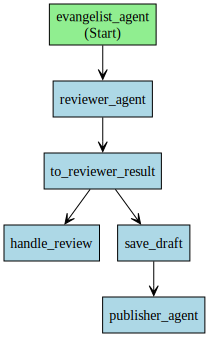

Workflow output: None
Workflow output: None


[2025-09-26 13:07:41 - c:\Users\kinfeylo\AppData\Local\miniforge3\envs\agentenv\Lib\site-packages\agent_framework_azure_ai\_chat_client.py:570 - ERROR] Error processing stream: Sorry, something went wrong.


Workflow output: None
Workflow output: None
done


ServiceResponseException: Sorry, something went wrong.

In [14]:
async with (
        AzureCliCredential() as credential,
        AzureAIAgentClient(async_credential=credential) as chat_client,
    ):
        evangelist_foundry_agent = chat_client.create_agent(
            name="EvangelistAgent",
            description="A technical evangelist writing a series of technical tutorials",
            instructions= EvangelistInstructions,
            tools=[HostedWebSearchTool()],
            response_format=EvangelistAgent
        )

        reviewer_foundry_agent = chat_client.create_agent(
            name="ReviewerAgent",
            description="A content reviewer review the tutorial draft",
            instructions=ContentReviewerInstructions,
            response_format=ReviewAgent
        )

        publisher_foundry_agent = chat_client.create_agent(
            name="PublisherAgent",
            description="A content publisher",
            instructions=PublisherInstructions,
            tools=HostedCodeInterpreterTool(),
            response_format=PublisherAgent
        )   

        try:
                # evangelist_chat_agent = ChatAgent(
                #     chat_client=evangelist_foundry_agent,
                #     tools=[HostedWebSearchTool()],
                #     name = "evangelist"
                # )

                # reviewer_chat_agent = ChatAgent(
                #     chat_client=reviewer_foundry_agent,
                #     name="reviewer",
                #     response_format=ReviewAgent
                    
                # )

                # publisher_chat_agent = ChatAgent(
                #     chat_client=publisher_foundry_agent,
                #     tools=HostedCodeInterpreterTool(),
                #     name="publisher"
                # )

          
                evangelist_agent = AgentExecutor(evangelist_foundry_agent, id="evangelist_agent")
                reviewer_agent = AgentExecutor(reviewer_foundry_agent, id="reviewer_agent")
                publisher_agent = AgentExecutor(publisher_foundry_agent, id="publisher_agent")

                workflow = (
                    WorkflowBuilder()
                        .set_start_executor(evangelist_agent)
                        .add_edge(evangelist_agent, reviewer_agent)
                        .add_edge(reviewer_agent, to_reviewer_result)
                        .add_multi_selection_edge_group(
                            to_reviewer_result,
                            [handle_review, save_draft],
                            selection_func=select_targets,
                        )
                        .add_edge(save_draft, publisher_agent)
                        .build()
                )

                # workflow = SequentialBuilder().participants([evangelist_chat_agent, reviewer_chat_agent, publisher_chat_agent]).build()
                print("Generating workflow visualization...")
                viz = WorkflowViz(workflow)
                # Print out the mermaid string.
                print("Mermaid string: \n=======")
                print(viz.to_mermaid())
                print("=======")
                # Print out the DiGraph string.
                print("DiGraph string: \n=======")
                print(viz.to_digraph())
                print("=======")
                svg_file = viz.export(format="svg")
                print(f"SVG file saved to: {svg_file}")

                if svg_file and os.path.exists(svg_file):
                    try:
                        # Preferred: direct SVG rendering
                        display(SVG(filename=svg_file))
                    except Exception as e:
                        print(f"⚠️ Direct SVG render failed: {e}. Falling back to raw HTML.")
                        try:
                            with open(svg_file, "r", encoding="utf-8") as f:
                                svg_text = f.read()
                            display(HTML(svg_text))
                        except Exception as inner:
                            print(f"❌ Fallback HTML render also failed: {inner}")
                else:
                    print("❌ SVG file not found. Ensure viz.export(format='svg') ran successfully.")

                
                task = """
                    You are a evangelist , need to write a  draft based on the following outline and the content provided in the link corresponding to the outline. After draft create , the reviewer check it , if it meets the requirements, it will be submitted to the publisher and save it as a Markdown file, otherwise need to rewrite draft until it meets the requirements.
                        The provided outline content and related links is as follows:

                    """ + OUTLINE_Content
                
                
                # outputs: list[list[ChatMessage]] = []
                # async for event in workflow.run_stream(task):
                #     if isinstance(event, WorkflowOutputEvent):
                #         outputs.append(cast(list[ChatMessage], event.data))
                #         print(f"Workflow output: {outputs[0]}")

                # # if outputs:
                # #     print("===== Final Conversation =====")
                # #     print(f"Final output from workflow: {outputs[-1][-1].text}")
                #     # for i, msg in enumerate(outputs[-1], start=1):
                #     #     name = "assistant" if msg.role == Role.ASSISTANT else "user"
                #     #     print(f"{'-' * 60}\n{i:02d} [{name}]\n{msg.text}")

                
                async for event in workflow.run_stream(task):
                    if isinstance(event, DatabaseEvent):
                        print(f"{event}")
                    if isinstance(event, WorkflowEvent):
                        print(f"Workflow output: {event.data}")



        finally:
            print("done")
